In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import requests
import io
import zipfile
import sdmx
import numpy as np
from scipy.interpolate import griddata

from joblib import Parallel, delayed
from ecb_yield_curve import ECBYieldCurve
from energy_option_pricing import EnergyOptionPricer

In [2]:
pricer = EnergyOptionPricer()

In [37]:
# Fetch European Central Bank yield curves for discount factors
yc_df = pricer.get_yield_curve(["SR_3M","SR_6M","SR_1Y","SR_2Y","SR_5Y","SR_10Y","SR_30Y"], start_period="2015-01-01")
df_disc = pricer.discount_factors_from_latest(yc_df)
# Process German power prices
prices, fwd_proxy = pricer.process_power_data("european_wholesale_electricity_price_data_daily.csv", country_iso="DEU", rolling_days=30)

In [38]:
# Compute forward proxies for normal vs crisis regimes
fwd_normal, fwd_crisis, prices_normal, prices_crisis = pricer.compute_forward_proxies_by_regime(
    prices, rolling_days=30,
    k_normal=2, k_crisis=3,
    rolling_window=30, rolling_factor=2.5
)

# Calibrate MC parameters for normal & crisis
params_normal = pricer.calibrate_mc_params(prices_normal, fwd_normal)
params_crisis = pricer.calibrate_mc_params(prices_crisis, fwd_crisis)

# Compute seasonality functions
theta_normal = pricer.compute_theta(prices_normal, fwd_normal)
theta_crisis = pricer.compute_theta(prices_crisis, fwd_crisis)

# Set option parameters
F0_normal = fwd_normal.iloc[-1]
F0_crisis = fwd_crisis.iloc[-1]
K_normal = F0_normal  # ATM strike
K_crisis = F0_crisis  # ATM strike

T = 1.0  # 1Y maturity

In [61]:
### 
#   crisis regime
###
F0 = F0_crisis
K = K_crisis
params = params_crisis
theta_func = theta_crisis

strikes = np.linspace(0.7*F0, 1.3*F0, 17)  
maturities = np.linspace(0.25, 1.0, 7)     

surface = []

# Compute option prices for different strikes and maturities to build respective surfaces
for T in maturities:
    F_T, dF_dF0, dF_dsig0, DF = pricer.generate_paths(
        F0, T, df_disc, params, theta_func,
        n_paths=100_000, n_steps=100
    )

    prices, deltas, vegas = pricer.price_options_from_paths(
        F_T, dF_dF0, dF_dsig0, DF, strikes
    )

    for i, K in enumerate(strikes):
        surface.append({
            "T": T,
            "K": K,
            "Price": prices[i],
            "Delta": deltas[i],
            "Vega": vegas[i]
        })

df_surface = pd.DataFrame(surface)

In [62]:
# If needed, retrive option price at a desired maturity and strike, here ATM and T = 1 year
points = df_surface[["T","K"]].values
values = df_surface["Price"].values

price_interp = griddata(points, values, (1.0, F0), method="linear")
print("Interpolated ATM 1Y price:", price_interp)

Interpolated ATM 1Y price: 28.149281526966824


In [70]:
stress_levels = [0.5, 1.0, 2.0, 5.0]  # +50%, +100%, +200%, +500%
for s in stress_levels:
    pnl = pricer.stress_scenario(F0, K, s, price_interp)
    print(f"Stress +{int(100*s)}% → P&L: {pnl:.2f}")

Stress +50% → P&L: -6.84
Stress +100% → P&L: 46.45
Stress +200% → P&L: 153.01
Stress +500% → P&L: 472.71


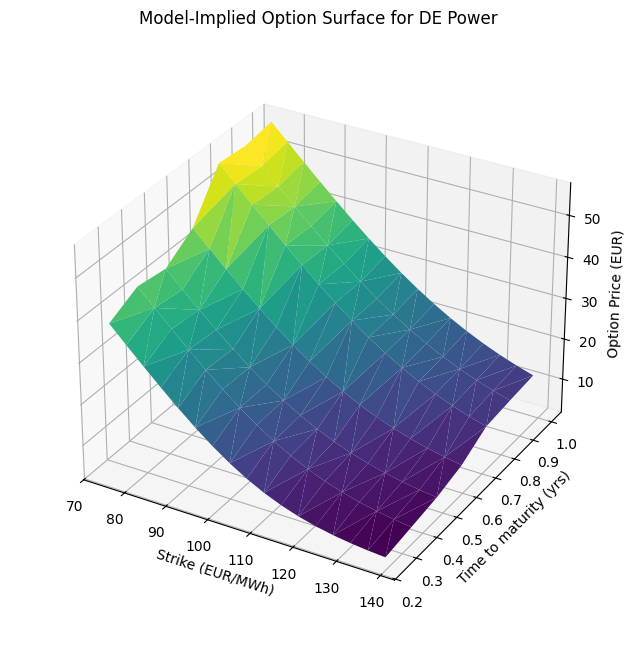

In [64]:
Ks = df_surface["K"].values
Ts = df_surface["T"].values
Ps = df_surface["Price"].values

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(Ks, Ts, Ps, cmap='viridis', edgecolor='none')
ax.set_xlabel('Strike (EUR/MWh)')
ax.set_ylabel('Time to maturity (yrs)')
ax.set_zlabel('Option Price (EUR)')
ax.set_title('Model-Implied Option Surface for DE Power')
ax.set_box_aspect(None, zoom=0.90)

In [65]:
K_grid = np.sort(df_surface["K"].unique())
T_grid = np.sort(df_surface["T"].unique())

Delta_grid = df_surface.pivot(index="T", columns="K", values="Delta").values
Vega_grid  = df_surface.pivot(index="T", columns="K", values="Vega").values

K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)

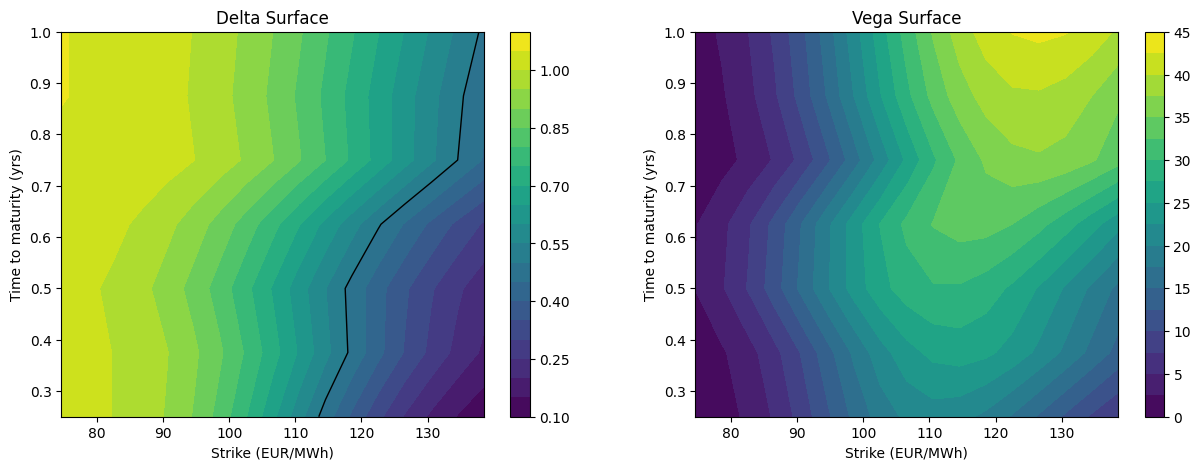

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 

cp = axes[0].contourf(K_mesh, T_mesh, Delta_grid, levels=20)
axes[0].contour(K_mesh, T_mesh, Delta_grid, levels=[0.5], colors='black', linewidths=1) # ATM
fig.colorbar(cp, ax=axes[0])
axes[0].set_xlabel("Strike (EUR/MWh)")
axes[0].set_ylabel("Time to maturity (yrs)")
axes[0].set_title("Delta Surface")

cp = axes[1].contourf(K_mesh, T_mesh, Vega_grid, levels=20)
fig.colorbar(cp, ax=axes[1])
axes[1].set_xlabel("Strike (EUR/MWh)")
axes[1].set_ylabel("Time to maturity (yrs)")
axes[1].set_title("Vega Surface");

In [51]:
# Set option parameters
F0_normal = fwd_normal.iloc[-1]
F0_crisis = fwd_crisis.iloc[-1]
K_normal = F0_normal  # ATM strike
K_crisis = F0_crisis  # ATM strike

T = 1.0  # 1Y maturity

# Hedged P&L simulation for normal regime
pnl_normal = pricer.hedged_pnl_simulation(
    F0_normal, K_normal, T, df_disc, params_normal, theta_func=theta_normal,
    n_paths=100_000) 


VaR99_normal, CVaR99_normal = pricer.compute_var_cvar(pnl_normal)
print("Normal regime 99% VaR:", round(VaR99_normal,2))
print("Normal regime 99% CVaR:", round(CVaR99_normal,2))

# Hedged P&L simulation for crisis regime
pnl_crisis = pricer.hedged_pnl_simulation(
    F0_crisis, K_crisis,T, df_disc, params_crisis, theta_func=theta_crisis,
    n_paths=100_000)

VaR99_crisis, CVaR99_crisis = pricer.compute_var_cvar(pnl_crisis)
print("Crisis regime 99% VaR:", round(VaR99_crisis,2))
print("Crisis regime 99% CVaR:", round(CVaR99_crisis,2))

Normal regime 99% VaR: -100.32
Normal regime 99% CVaR: -493.42
Crisis regime 99% VaR: -194.38
Crisis regime 99% CVaR: -453.74


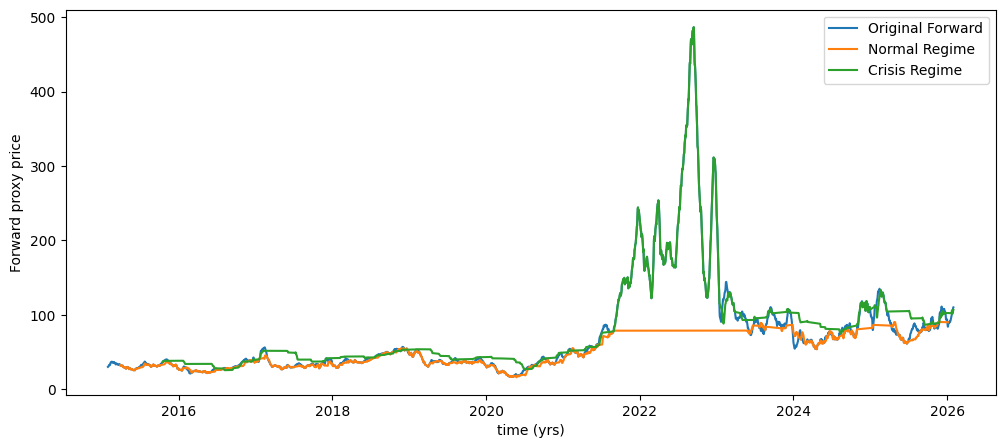

In [68]:
plt.figure(figsize=(12,5))
plt.plot(fwd_proxy.index, fwd_proxy, label="Original Forward")
plt.plot(fwd_normal.index, fwd_normal, label="Normal Regime")
plt.plot(fwd_crisis.index, fwd_crisis, label="Crisis Regime")
plt.xlabel("time (yrs)")
plt.ylabel("Forward proxy price")
plt.legend()

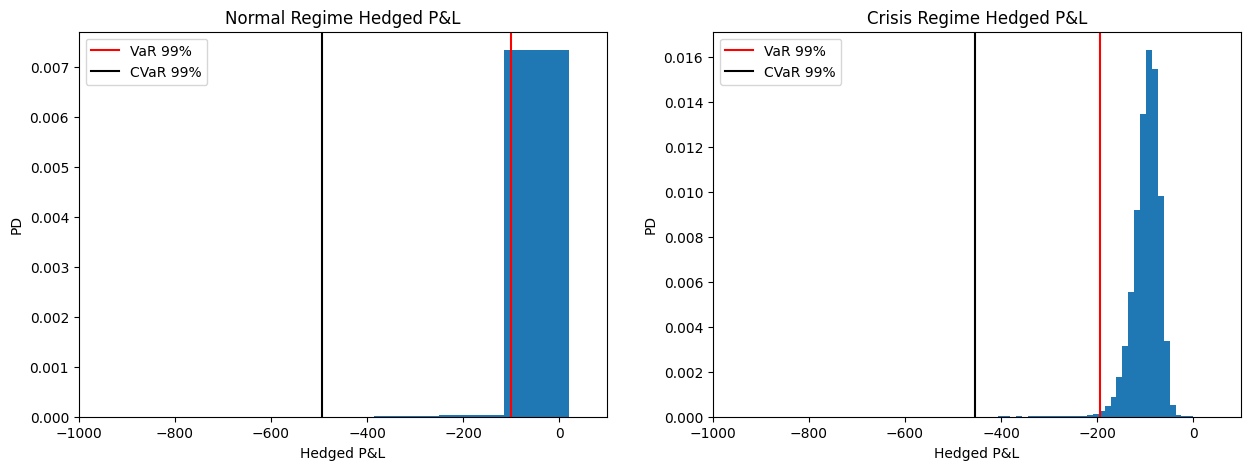

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

axes[0].hist(pnl_normal, bins=2000, density=True)
axes[0].axvline(VaR99_normal, color="red", label="VaR 99%")
axes[0].axvline(CVaR99_normal, color="black", label="CVaR 99%")
axes[0].set_xlabel("Hedged P&L")
axes[0].set_ylabel("PD")
axes[0].set_xlim(-1000,100)
axes[0].legend()
axes[0].set_title("Normal Regime Hedged P&L")

axes[1].hist(pnl_crisis, bins=2000, density=True)
axes[1].axvline(VaR99_crisis, color="red", label="VaR 99%")
axes[1].axvline(CVaR99_crisis, color="black", label="CVaR 99%")
axes[1].set_xlabel("Hedged P&L")
axes[1].set_ylabel("PD")
axes[1].set_xlim(-1000,100)
axes[1].legend()
axes[1].set_title("Crisis Regime Hedged P&L");